Set up

In [1]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

create training data

In [4]:
data = pd.read_csv("data/next_step_data.csv")

In [5]:
data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
0,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513443e+09
1,2171.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
2,2171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
3,2171.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
4,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835360,568669.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687208e+09
5835361,568669.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687210e+09
5835362,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687211e+09
5835363,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.218,0.827,NaN,1.0,1.687216e+09


In [6]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
n_samples = 100000

## one sample for train, only to see if it learns that one example
# train_data = train_data[:n_samples].copy()
test_data = test_data[:n_samples].copy()

In [7]:
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000,1.0,1.602174e+09
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.000,0.307,0.500,0.64,0.364,0.644,0.200,1.0,1.672064e+09
108777,16506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN,1.0,1.678826e+09
5428722,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200,1.0,1.682856e+09
3125710,191189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474,1.0,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729440,70057.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.640,0.700,0.88,0.667,0.908,NaN,1.0,1.585233e+09
224451,24133.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.424,0.880,0.685,1.00,0.545,0.865,0.300,1.0,1.585000e+09
5099919,315975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.917,NaN,0.464,0.40,NaN,NaN,0.522,1.0,1.564950e+09
3583513,210803.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000,0.894,0.640,0.785,1.00,0.346,0.865,NaN,1.0,1.638079e+09


In [8]:
# specific sessions to track
# session_id = [4478682, 5198989, 3511929, 4134494, 217809, 108777, 4313511, 4184746, 3694380, 2051828, 5151980, 5447081, 3640067, 4856734, 5313162, 4203617, 1813788, 3485634, 4876271, 2213497, 5025916, 274747, 4621927, 3888559, 2592816, 4325322, 3673390]
# test_data = test_data.loc[session_id]

model set up

In [9]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [10]:
# given a processed dataframe, return data and target numpy arrays
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    print("===== from create_model_data ======")
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    print("data_scores: ", data_scores)
    print("target: ", target)
    return data_scores, target

In [11]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [12]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [13]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

filter out the non-repeats first for ground truth as the base set

In [14]:
# find whether it is a repeat domain or not
def assign_repeat(df):
    print("================= assign_repeat =============")
    # default to false
    df[repeat_columns] = True
    for idx, row in df.iterrows():
        assignment = True
        # print("the row ", row)
        for encoding_col, score_col in zip(encoding_columns, score_columns):
            # print("columns:" , encoding_col, score_col)
            # Find rows where encoding column is 1
            encoding_is_1 = row[encoding_col] == 1
            
            # Check if the corresponding score column is NaN for those rows
            is_nan = pd.isna(row[score_col])
            # print("encoding is 1 and is nan: ", encoding_is_1, is_nan)
            # Combine the conditions: where encoding column is 1 and score column is NaN
            condition = encoding_is_1 & is_nan
            # print("condition: ", condition)
            if condition:
                assignment = False
                break
            
        # Set the 'repeat' column to True where the condition is met, False otherwise
        # print("assignment: ", assignment)
        df.loc[idx, 'repeat'] = assignment
    # print("after assignment: ", df)
    return df

In [15]:
test_data_assigned  = assign_repeat(test_data)

================= assign_repeat =============


In [16]:
test_data_nonrepeat = test_data_assigned[test_data_assigned.repeat == False].copy()

In [17]:
# make test data copies
ground_truth_test_data = test_data_assigned.copy()
random_test_data = test_data_assigned.copy()
best_test_data = test_data_assigned.copy()

create encoding and find prediction

In [18]:
# return predictions, loss, and mae
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy()

In [19]:
def create_random_encoding(df):
    """
    Returns a numpy array of the same shape as df with 0s everywhere except for 
    a randomly chosen NaN position in each row, which is marked with a 1.

    Parameters:
    df (pd.DataFrame): Input dataframe.

    Returns:
    np.ndarray: Array with the same shape as df, containing 0s and a single 1 in a NaN position per row.
    """
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    # Create an output array of zeros
    output = np.zeros(df.shape, dtype=int)

    # Iterate over each row
    for i, row in enumerate(df.isna().values):
        nan_indices = np.where(row)[0]  # Find indices where NaN is present
        if len(nan_indices) > 0:
            chosen_index = np.random.choice(nan_indices)  # Pick one at random
            output[i, chosen_index] = 1  # Set the chosen position to 1
    
    return output


In [20]:
def find_random_predictions(data):
    x, y = create_model_data(data) # create scores with missing indicators and target
    e = data[encoding_columns].to_numpy()
    x_random = add_encoding(x, e)
    predictions = predict(model, x_random, torch.from_numpy(y).float())
    return predictions, e

In [21]:
# create random encoding
random_encoding = create_random_encoding(random_test_data[score_columns])
random_test_data[encoding_columns] = random_encoding

In [22]:
# find random prediction
random_prediction, random_encoding = find_random_predictions(random_test_data)
random_test_data[target_columns] = random_prediction
random_test_data

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.214 0.786 0.    ... 0.    0.533 0.467]
 [0.779 0.221 0.91  ... 0.135 0.    0.   ]
 [1.    0.    1.    ... 0.454 1.    0.   ]]
target:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0. nan]
 ...
 [ 0. nan nan ... nan nan  0.]
 [ 0.  0.  0. ...  0.  0. nan]
 [ 0.  0.  0. ...  0.  0.  0.]]


,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0,0,0,0,0,0,0,1,0,...,-0.014390,0.487917,0.004378,-0.025731,-0.005009,-0.004148,0.002992,-0.006646,True,1.602174e+09
4478682,268337.0,0,0,0,0,0,0,0,0,0,...,0.002268,-0.010454,0.011160,-0.000309,-0.006795,-0.000049,-0.008678,-0.011196,True,1.672064e+09
108777,16506.0,0,0,0,0,0,0,0,0,0,...,0.006116,-0.001323,0.004081,0.003141,0.001826,-0.007262,-0.002123,0.572504,True,1.678826e+09
5428722,333131.0,0,0,0,0,0,1,0,0,0,...,-0.009555,-0.004032,0.028013,0.005450,-0.013470,0.007487,-0.003746,-0.014447,True,1.682856e+09
3125710,191189.0,0,0,0,0,0,0,0,1,0,...,0.000806,0.496710,0.011231,-0.007925,-0.003851,0.001144,-0.003738,0.001925,True,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729440,70057.0,0,0,0,0,0,0,1,0,0,...,0.558813,0.013916,-0.007180,0.000774,0.009747,-0.009354,-0.001303,-0.002102,True,1.585233e+09
224451,24133.0,0,0,0,0,0,0,0,0,0,...,-0.003193,-0.008998,0.015561,-0.012078,-0.003376,-0.005563,-0.011907,0.003639,True,1.585000e+09
5099919,315975.0,0,0,0,0,0,0,0,0,1,...,-0.007039,0.007109,0.471864,0.002792,-0.000910,0.009378,-0.009894,-0.002801,True,1.564950e+09
3583513,210803.0,0,0,0,0,0,0,0,0,0,...,0.005274,-0.005830,-0.009153,-0.007750,-0.003159,0.001168,-0.002273,0.577158,True,1.638079e+09


In [23]:
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [24]:
def predict_all_domains(x, y):
    prediction_list = []
    rows, cols = y.shape
    # loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
    for domain in range(14):
        encoding = create_single_encoding(rows, cols, domain)
        x_single = add_encoding(x, encoding)
        single_prediction = predict(model, x_single, torch.from_numpy(y).float())
        prediction_list.append(single_prediction[:, domain])
    return prediction_list

In [25]:
def find_best_idx_pred(x, y, original):
    prediction_lst = predict_all_domains(x, y)
    prediction_matrix = np.column_stack(prediction_lst)  # Shape: (100000, 14)
    difference = prediction_matrix - original
    # Find the index of the max difference for each row
    max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
    rows, cols = y.shape
    # Create a zero matrix of shape (100000, 14)
    encoding = np.zeros((rows, cols), dtype=int)
    # Assign 1s at the max_indices positions to create the full encoding matrix with best domains
    encoding[np.arange(rows), max_indices] = 1
    # create a zero matrix of shape (100000, 14)
    predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
    # Fill in the max values at their corresponding positions
    predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
    return encoding, predictions

In [26]:
def max_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    max_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    max_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            max_idx = np.argmax(valid_differences)  # Find index of max value (relative to valid_indices)
            max_indices[i] = valid_indices[max_idx]  # Store original column index
            max_values[i] = prediction_matrix[i, valid_indices[max_idx]]  # Get corresponding prediction value

    return max_values, max_indices

In [27]:
def reconstruct_max_matrices(max_values, max_indices, shape):
    max_values_matrix = np.zeros(shape)  # Matrix for max values
    max_indices_matrix = np.zeros(shape, dtype=int)  # Matrix for 1s at max indices

    # Iterate through rows
    for i in range(shape[0]):
        if not np.isnan(max_indices[i]):  # Ensure there's a valid index
            col_idx = int(max_indices[i])
            max_values_matrix[i, col_idx] = max_values[i]
            max_indices_matrix[i, col_idx] = 1  # Mark the index with 1

    return max_values_matrix, max_indices_matrix

In [28]:
# create best encoding
x_tmp, y_tmp = create_model_data(best_test_data) # create scores with missing indicators and target
rows, cols = y_tmp.shape
prediction_list = []
# loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = add_encoding(x_tmp, encoding)
    print("data put in model", tmp_single)
    single_prediction = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.214 0.786 0.    ... 0.    0.533 0.467]
 [0.779 0.221 0.91  ... 0.135 0.    0.   ]
 [1.    0.    1.    ... 0.454 1.    0.   ]]
target:  [[0.    0.    0.    ... 0.    0.081 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 ...
 [0.      nan   nan ...   nan   nan 0.522]
 [0.    0.9   0.    ... 0.    0.      nan]
 [0.989 0.    0.    ... 0.    0.546 0.   ]]
============= domain 1
encoding:  [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
data put in model tensor([[1.0000, 0.0000, 0.0000,  ..., 0.9190, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.3560, 0.2000, 0.8000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..

In [29]:
x_tmp

array([[0.526, 0.474, 0.02 , ..., 0.919, 1.   , 0.   ],
       [0.526, 0.474, 0.11 , ..., 0.356, 0.2  , 0.8  ],
       [1.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.214, 0.786, 0.   , ..., 0.   , 0.533, 0.467],
       [0.779, 0.221, 0.91 , ..., 0.135, 0.   , 0.   ],
       [1.   , 0.   , 1.   , ..., 0.454, 1.   , 0.   ]])

In [30]:
prediction_list

[array([0.42421883, 0.5049609 , 0.9779678 , ..., 0.269211  , 0.78067255,
        0.9779667 ], dtype=float32),
 array([0.05316141, 0.1483829 , 0.98007566, ..., 0.5879973 , 0.9067631 ,
        0.97662175], dtype=float32),
 array([0.1462817 , 0.9476464 , 0.96433383, ..., 0.7481566 , 0.95601016,
        0.6405007 ], dtype=float32),
 array([0.3306931 , 0.37153944, 0.90246654, ..., 0.23649427, 0.90181524,
        0.89480066], dtype=float32),
 array([0.11111826, 0.17349893, 0.93166447, ..., 0.08682654, 0.5743863 ,
        0.92185   ], dtype=float32),
 array([0.06135439, 0.06429052, 0.4675113 , ..., 0.46072373, 0.9171147 ,
        0.6734154 ], dtype=float32),
 array([0.04934064, 0.19785866, 0.913955  , ..., 0.45046207, 0.9563673 ,
        0.59028465], dtype=float32),
 array([0.48791665, 0.10046811, 0.528789  , ..., 0.9120596 , 0.9114108 ,
        0.6317404 ], dtype=float32),
 array([0.09235591, 0.28050837, 0.9787704 , ..., 0.47186366, 0.6655221 ,
        0.6369015 ], dtype=float32),
 array([0.

In [31]:
prediction_matrix = np.column_stack(prediction_list)  # Shape: (100000, 14)
difference = prediction_matrix - np.nan_to_num(best_test_data[score_columns].to_numpy())

# find max indices
max_values, max_indices = max_prediction_from_difference(difference, prediction_matrix, best_test_data[score_columns].to_numpy())
# reconstruct matrices
best_predictions, best_encoding = reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)

'''
rows, cols = prediction_matrix.shape
# Find the index of the max difference for each row
max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
# Create a zero matrix of shape (100000, 14)
best_encoding = np.zeros((rows, cols), dtype=int)
# Assign 1s at the max_indices positions to create the full encoding matrix with best domains
best_encoding[np.arange(rows), max_indices] = 1
# create a zero matrix of shape (100000, 14)
best_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
# Fill in the max values at their corresponding positions
best_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
'''

'\nrows, cols = prediction_matrix.shape\n# Find the index of the max difference for each row\nmax_indices = np.argmax(difference, axis=1)  # Shape: (100000,)\n# Create a zero matrix of shape (100000, 14)\nbest_encoding = np.zeros((rows, cols), dtype=int)\n# Assign 1s at the max_indices positions to create the full encoding matrix with best domains\nbest_encoding[np.arange(rows), max_indices] = 1\n# create a zero matrix of shape (100000, 14)\nbest_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type\n# Fill in the max values at their corresponding positions\nbest_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]\n'

In [32]:
prediction_matrix

array([[0.42421883, 0.05316141, 0.1462817 , ..., 0.13206464, 0.12930726,
        0.9768177 ],
       [0.5049609 , 0.1483829 , 0.9476464 , ..., 0.36525524, 0.65326107,
        0.203392  ],
       [0.9779678 , 0.98007566, 0.96433383, ..., 0.736803  , 0.9710634 ,
        0.57250416],
       ...,
       [0.269211  , 0.5879973 , 0.7481566 , ..., 0.5930616 , 0.6722122 ,
        0.534968  ],
       [0.78067255, 0.9067631 , 0.95601016, ..., 0.35314584, 0.872119  ,
        0.5771579 ],
       [0.9779667 , 0.97662175, 0.6405007 , ..., 0.88227177, 0.5496632 ,
        0.9734024 ]], dtype=float32)

In [33]:
ground_truth_test_data[target_columns]

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.500,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729440,0.884,1.00,1.000,0.900,0.594,NaN,NaN,NaN,0.640,0.700,0.88,0.667,0.908,NaN
224451,0.473,0.92,0.889,1.000,0.639,0.133,0.222,0.424,0.880,0.685,1.00,0.545,0.865,0.300
5099919,0.214,NaN,NaN,0.214,0.050,0.474,NaN,0.917,NaN,0.464,0.40,NaN,NaN,0.522
3583513,0.779,0.90,1.000,0.950,0.561,1.000,1.000,0.894,0.640,0.785,1.00,0.346,0.865,NaN


In [34]:
best_test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.500,0.80,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729440,0.884,1.00,1.000,0.900,0.594,NaN,NaN,NaN,0.640,0.700,0.88,0.667,0.908,NaN
224451,0.473,0.92,0.889,1.000,0.639,0.133,0.222,0.424,0.880,0.685,1.00,0.545,0.865,0.300
5099919,0.214,NaN,NaN,0.214,0.050,0.474,NaN,0.917,NaN,0.464,0.40,NaN,NaN,0.533
3583513,0.779,0.91,1.000,0.950,0.561,1.000,1.000,0.894,0.640,0.785,1.00,0.346,0.865,NaN


In [35]:
difference

array([[-0.10178117,  0.03316141, -0.0017183 , ...,  0.00506464,
         0.04830726, -0.02318227],
       [-0.02103911,  0.0383829 , -0.05235362, ...,  0.00125524,
         0.00926107,  0.003392  ],
       [-0.0220322 , -0.01992434, -0.03566617, ..., -0.003197  ,
        -0.02893662,  0.57250416],
       ...,
       [ 0.05521099,  0.58799732,  0.74815661, ...,  0.59306163,
         0.67221218,  0.00196802],
       [ 0.00167255, -0.00323692, -0.04398984, ...,  0.00714584,
         0.00711901,  0.57715791],
       [-0.02203327, -0.02337825,  0.04750072, ..., -0.05672823,
         0.00366319, -0.02659762]])

In [36]:
max_indices

array([ 7., nan, 13., ...,  2., 13., nan])

In [37]:
best_encoding

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
best_predictions

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.57250416],
       ...,
       [0.        , 0.        , 0.74815661, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.57715791],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [39]:
best_test_data[encoding_columns] = best_encoding
best_test_data[target_columns] = best_predictions

separate by repeat vs non repeat

In [40]:
# random assignment
print("ground truth")
ground_truth_test_data_final  = assign_repeat(ground_truth_test_data)
print("random")
random_test_data_final  = assign_repeat(random_test_data)
print("best")
best_test_data_final  = assign_repeat(best_test_data)

ground truth
================= assign_repeat =============
random
================= assign_repeat =============
best
================= assign_repeat =============


filter depending on number of known domains

In [41]:
# filter rows based on number of missing values (denoted by nans) the session has
def filter_n_missing(df, n_missing):
    global score_columns
    # only use the score columns when counting 0s
    scores = df[score_columns]
    # Count number of nans in each row
    missing_count = scores.isna().sum(axis=1)
    
    # Filter rows with n_zeros number of zeros
    filtered_rows = df[missing_count == n_missing]
    return filtered_rows

In [42]:
# debug print
def debug_filter_print(df):
    n = df.iloc[0][score_columns].isna().sum()
    total_sessions = df.shape[0]
    print("# of missing = %d, # of total sessions = %d" % (n, total_sessions))
    print(np.isnan(df[score_columns]).sum(axis=1).sum() == n * total_sessions)

In [43]:
ground_truth_test_data_n = dict()
random_test_data_n = dict()
best_test_data_n = dict()

In [44]:
for n in range(1, 14):
    print("======================= filter n missing: n = %d =========================" % n)
    print("============ ground truth ===============")
    tmp = filter_n_missing(ground_truth_test_data, n_missing=n)
    ground_truth_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============ random ================")
    tmp = filter_n_missing(random_test_data, n_missing=n)
    random_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============= best ==================")
    tmp = filter_n_missing(best_test_data, n_missing=n)
    best_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

======================= filter n missing: n = 1 =========================
============ ground truth ===============
# of missing = 1, # of total sessions = 21428
True
============ random ================
# of missing = 1, # of total sessions = 21428
True
============= best ==================
# of missing = 1, # of total sessions = 21428
True
======================= filter n missing: n = 2 =========================
============ ground truth ===============
# of missing = 2, # of total sessions = 14721
True
============ random ================
# of missing = 2, # of total sessions = 14721
True
============= best ==================
# of missing = 2, # of total sessions = 14721
True
======================= filter n missing: n = 3 =========================
============ ground truth ===============
# of missing = 3, # of total sessions = 10891
True
============ random ================
# of missing = 3, # of total sessions = 10891
True
============= best ==================
# of missing = 3, #

In [45]:
ground_truth_test_data_final[score_columns] ## all three should be the same -> current score shouldn't be modified

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.500,0.80,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729440,0.884,1.00,1.000,0.900,0.594,NaN,NaN,NaN,0.640,0.700,0.88,0.667,0.908,NaN
224451,0.473,0.92,0.889,1.000,0.639,0.133,0.222,0.424,0.880,0.685,1.00,0.545,0.865,0.300
5099919,0.214,NaN,NaN,0.214,0.050,0.474,NaN,0.917,NaN,0.464,0.40,NaN,NaN,0.533
3583513,0.779,0.91,1.000,0.950,0.561,1.000,1.000,0.894,0.640,0.785,1.00,0.346,0.865,NaN


In [46]:
random_test_data_final[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.500,0.80,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729440,0.884,1.00,1.000,0.900,0.594,NaN,NaN,NaN,0.640,0.700,0.88,0.667,0.908,NaN
224451,0.473,0.92,0.889,1.000,0.639,0.133,0.222,0.424,0.880,0.685,1.00,0.545,0.865,0.300
5099919,0.214,NaN,NaN,0.214,0.050,0.474,NaN,0.917,NaN,0.464,0.40,NaN,NaN,0.533
3583513,0.779,0.91,1.000,0.950,0.561,1.000,1.000,0.894,0.640,0.785,1.00,0.346,0.865,NaN


score aggregate

In [47]:
def overall_avg_improvement_with_std(df):
    pred_score = df[target_columns].to_numpy()
    cur_score = df[score_columns].to_numpy()
    encoding = df[encoding_columns].to_numpy()

    print("prediction score: ", pred_score)
    print("current score: ", cur_score)
    print("encoding: ", encoding)

    pred_score = np.nan_to_num(pred_score, nan=0) * encoding
    cur_score = np.nan_to_num(cur_score, nan=0) * encoding
    assert pred_score.shape == cur_score.shape and cur_score.shape == encoding.shape

    # Compute improvement
    improvement = encoding * (pred_score - cur_score)

    # Extract nonzero values
    nonzero_improvement = improvement[improvement != 0]

    if len(nonzero_improvement) == 0:
        avg_improvement = 0
        std_dev = 0
        print("No sessions with nonzero improvement")
    else:
        avg_improvement = np.mean(nonzero_improvement)
        std_dev = np.std(nonzero_improvement, ddof=1)  # Using sample standard deviation (ddof=1)

        print("Number of predicted domains:", len(nonzero_improvement))
        print("Average improvement:", avg_improvement)
        print("Standard deviation:", std_dev)

    return avg_improvement, std_dev

In [48]:
nonrepeat_ground_truth_avg = []
nonrepeat_random_avg = []
nonrepeat_best_avg = []

nonrepeat_ground_truth_std = []
nonrepeat_random_std = []
nonrepeat_best_std = []

In [49]:
for n in range(1, 14):
    print("========= %d missing" % n)
    print("----ground truth----")
    # ground truth
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_nonrepeat) != 0:
        nonrepeat_ground_truth_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_ground_truth_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_ground_truth_avg.append(0)
        nonrepeat_ground_truth_std.append(0)

    print("----random----")
    # random
    temp_nonrepeat = random_test_data_n[n][random_test_data_n[n].repeat == False]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_random_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_random_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_random_avg.append(0)
        nonrepeat_random_std.appen(0)
    
    print("----best----")
    # best
    temp_nonrepeat = best_test_data_n[n][best_test_data_n[n].repeat == False]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_best_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_best_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
    else:
        nonrepeat_best_avg.append(0)
        nonrepeat_best_std.append(0)

========= 1 missing
----ground truth----
prediction score:  [[0.632 0.36  1.    1.    0.361 0.667 0.278 0.333 0.16  0.538 1.    0.376
  0.806 0.3  ]
 [0.429 0.05  1.    0.2   0.04  0.568 0.57  0.817 0.05  0.493 1.    0.286
  0.582 0.554]
 [1.    0.    1.    0.157 0.    0.053 0.55  0.85  0.16  0.272 1.    0.143
  0.206 0.874]
 [0.443 0.55  0.815 0.95  0.477 0.12  0.844 0.917 0.42  0.823 0.76  0.382
  0.47  0.853]
 [1.    1.    0.415 0.388 0.174 0.88  0.278 0.647 1.    1.    1.    0.182
  0.773 0.96 ]
 [0.429 0.35  1.    0.172 0.04  0.232 0.5   0.55  0.2   0.4   1.    0.364
  0.218 0.047]
 [1.    1.    1.    1.    0.755 0.347 0.889 1.    1.    1.    1.    0.794
  1.    1.   ]
 [0.571 0.263 0.787 0.257 0.125 0.652 0.563 0.283 0.85  0.357 0.4   0.571
  0.682 0.92 ]
 [0.968 0.15  0.593 1.    0.419 0.737 0.34  0.667 0.813 1.    1.    0.545
  0.984 1.   ]
 [0.632 0.    1.    0.5   0.484 1.    0.53  1.    0.25  0.846 0.84  0.343
  0.93  0.487]
 [0.937 0.54  1.    0.963 0.664 0.027 1.    0.    

Prediction accuracy

In [50]:
def plot_error_by_nan_count_nonzero_only(prediction_matrix, ground_truth_df, metric="mae"):
    """
    Plots error per number of NaNs in score columns with error bars, considering only nonzero values.

    Parameters:
    prediction_matrix (np.ndarray): 2D NumPy array of predicted values.
    ground_truth_df (pd.DataFrame): DataFrame containing ground truth and score columns.
    metric (str): "mae" for Mean Absolute Error, "mse" for Mean Squared Error.
    """
    global score_columns  # List of score column names
    global target_columns  # List of target columns
    global encoding_columns  # List of encoding columns

    mean_errors_list = []
    error_std_list = []
    nan_counts = list(range(1, 14))  # Checking sessions with 1 to 13 NaNs

    for n in nan_counts:
        filtered_df = filter_n_missing(ground_truth_df, n)  # Filter by NaN count
        
        if filtered_df.empty:  # Skip if no data
            mean_errors_list.append(np.nan)
            error_std_list.append(np.nan)
            continue

        # Correctly map DataFrame indices to NumPy indices
        valid_indices = ground_truth_df.index.get_indexer(filtered_df.index)
        valid_indices = valid_indices[valid_indices >= 0]  # Ensure only valid indices are used

        # Extract matrices
        ground_truth_matrix = np.nan_to_num(filtered_df[target_columns].to_numpy() * filtered_df[encoding_columns].to_numpy())
        filtered_prediction_matrix = prediction_matrix[valid_indices] * filtered_df[encoding_columns].to_numpy()

        # Ensure matrices have the same shape
        assert filtered_prediction_matrix.shape == ground_truth_matrix.shape, "Mismatch in matrix shapes"

        # Compute improvement (errors)
        errors = np.abs(filtered_prediction_matrix - ground_truth_matrix) if metric == "mae" else (filtered_prediction_matrix - ground_truth_matrix) ** 2

        # Extract only nonzero errors
        nonzero_errors = errors[errors != 0]

        if len(nonzero_errors) == 0:
            mean_errors_list.append(np.nan)
            error_std_list.append(np.nan)
        else:
            mean_errors_list.append(np.mean(nonzero_errors))
            error_std_list.append(np.std(nonzero_errors, ddof=1))  # Sample standard deviation

    # Convert to numpy arrays
    mean_errors = np.array(mean_errors_list)
    error_std = np.array(error_std_list)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(nan_counts, mean_errors, yerr=error_std, fmt='-o', capsize=5, color='b', alpha=0.7)
    plt.xlabel("Number of NaNs in Score Columns")
    plt.ylabel("Error (Nonzero Only)")
    plt.title(f"{metric.upper()} by Missing Domains (Nonzero Only)")
    plt.xticks(nan_counts)
    plt.ylim(-np.nanmax(error_std) * 1.1, np.nanmax(mean_errors + error_std) * 1.1 if not np.isnan(np.nanmax(mean_errors)) else 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()

In [51]:
x_tmp, y_tmp = create_model_data(ground_truth_test_data_final) # create scores with missing indicators and target
rows, cols = y_tmp.shape
encoding = ground_truth_test_data_final[encoding_columns].to_numpy()
print("encoding: ", encoding)
x_train_tmp = add_encoding(x_tmp, encoding)
print("data put in model", x_train_tmp)
ground_truth_prediction = predict(model, x_train_tmp, torch.from_numpy(y_tmp).float())

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.214 0.786 0.    ... 0.    0.533 0.467]
 [0.779 0.221 0.91  ... 0.135 0.    0.   ]
 [1.    0.    1.    ... 0.454 1.    0.   ]]
target:  [[0.    0.    0.    ... 0.    0.081 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 ...
 [0.      nan   nan ...   nan   nan 0.522]
 [0.    0.9   0.    ... 0.    0.      nan]
 [0.989 0.    0.    ... 0.    0.546 0.   ]]
encoding:  [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]
data put in model tensor([[0.0000, 0.0000, 0.0000,  ..., 0.9190, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3560, 0.2000, 0.8000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000

Plot Results

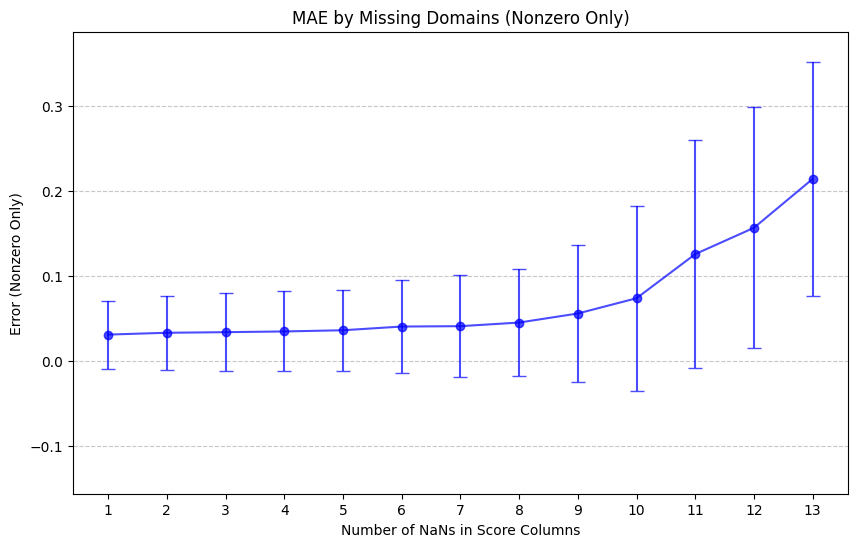

In [52]:
plot_error_by_nan_count_nonzero_only(ground_truth_prediction, ground_truth_test_data_final, metric="mae")  # Use "mse" for Mean Squared Error

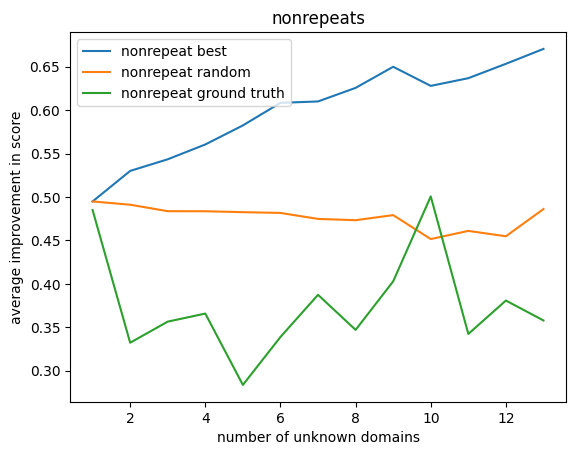

Bad pipe message: %s [b'\x15\x88\xbe\xdfe_M\xb4L\x81.o\x89\xa9\xf6\xcf{\xa3\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05', b"\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\xc0&\xc0

In [57]:
plt.figure()
plt.plot(range(1, 14), nonrepeat_best_avg, label="nonrepeat best")
plt.plot(range(1, 14), nonrepeat_random_avg, label="nonrepeat random")
plt.plot(range(1, 14), nonrepeat_ground_truth_avg, label="nonrepeat ground truth")
plt.xlabel("number of unknown domains")
plt.ylabel("average improvement in score")
plt.title("nonrepeats")
plt.legend()
plt.show()

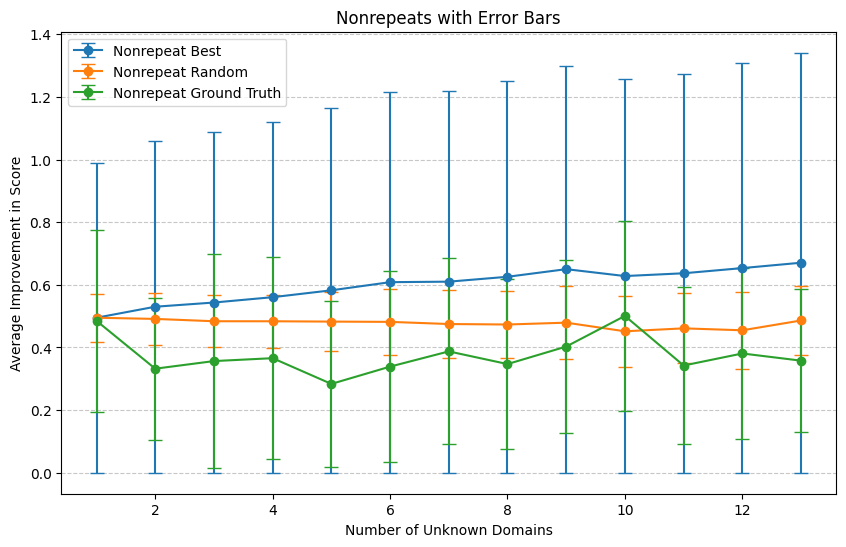

In [53]:
# Define x-axis values (number of unknown domains)
x_values = range(1, 14)

# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(x_values, nonrepeat_best_avg, yerr=nonrepeat_best_std, label="Nonrepeat Best", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_random_avg, yerr=nonrepeat_random_std, label="Nonrepeat Random", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_ground_truth_avg, yerr=nonrepeat_ground_truth_std, label="Nonrepeat Ground Truth", fmt='-o', capsize=5)

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Improvement in Score")
plt.title("Nonrepeats with Error Bars")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

trace

In [54]:
random_test_data_n[2][random_test_data_n[2].repeat == False]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
4134494,240716.0,0,0,0,0,0,0,1,0,0,...,0.483269,0.002313,-0.005556,0.010413,-0.002984,0.008233,0.002245,-0.006323,False,1.573090e+09
2647759,167488.0,0,0,0,0,0,0,1,0,0,...,0.468794,0.003601,0.009121,0.012663,0.004357,-0.008881,0.001076,0.001043,False,1.556046e+09
1835628,136434.0,0,0,0,0,0,0,1,0,0,...,0.620679,0.009639,0.008209,0.004231,0.007506,-0.015128,0.001937,0.004721,False,1.670880e+09
1577152,125246.0,0,0,0,0,0,0,0,0,0,...,0.003574,-0.004446,0.006550,-0.012851,-0.002015,0.009141,-0.004564,0.551326,False,1.534870e+09
412577,43440.0,0,0,0,0,0,0,0,0,0,...,0.000558,0.004790,0.000841,0.007093,0.003841,0.001799,-0.003482,0.421774,False,1.641832e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101413,235924.0,0,0,0,0,0,0,0,0,0,...,0.006762,-0.001832,0.002907,0.015948,-0.004509,0.003326,-0.008405,0.578331,False,1.558703e+09
253013,27901.0,0,0,0,0,0,0,0,0,0,...,-0.002801,-0.003289,0.008562,0.001872,-0.004931,-0.002695,0.005506,0.539889,False,1.611782e+09
3756847,220057.0,0,0,0,0,0,0,1,0,0,...,0.450820,0.004205,-0.007214,-0.009580,0.001148,0.002242,0.010741,-0.007242,False,1.592850e+09
4593647,274123.0,0,0,0,0,0,0,0,1,0,...,0.004977,0.579057,-0.004920,-0.000470,-0.001716,0.001357,-0.004762,0.001628,False,1.580932e+09


In [55]:
best_test_data_n[2][best_test_data_n[2].repeat == False]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
4134494,240716.0,0,0,0,0,0,0,1,0,0,...,0.483269,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,False,1.573090e+09
2647759,167488.0,0,0,0,0,0,0,1,0,0,...,0.468794,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,False,1.556046e+09
1835628,136434.0,0,0,0,0,0,0,1,0,0,...,0.620679,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,False,1.670880e+09
1577152,125246.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.551326,False,1.534870e+09
412577,43440.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.421774,False,1.641832e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101413,235924.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.578331,False,1.558703e+09
253013,27901.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.539889,False,1.611782e+09
3756847,220057.0,0,0,0,0,0,0,0,1,0,...,0.000000,0.529294,0.0,0.0,0.0,0.0,0.0,0.000000,False,1.592850e+09
4593647,274123.0,0,0,0,0,0,0,0,1,0,...,0.000000,0.579057,0.0,0.0,0.0,0.0,0.0,0.000000,False,1.580932e+09


trace

In [ ]:
session_id = []

In [ ]:
test_data[encoding_columns].head(1)

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding
5198989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
ids = []

In [ ]:
for n in range(1, 14):
    temp_repeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_repeat) != 0:
        ids.append(temp_repeat.index[0])
    if len(temp_nonrepeat) != 0:
        ids.append(temp_nonrepeat.index[0])

In [ ]:
ids

[5198989,
 3511929,
 4134494,
 217809,
 108777,
 4313511,
 4184746,
 3694380,
 2051828,
 5151980,
 5447081,
 3640067,
 4856734,
 5313162,
 4203617,
 1813788,
 3485634,
 4876271,
 2213497,
 5025916,
 274747,
 4621927,
 3888559,
 2592816,
 4325322,
 3673390]